In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import sys
import os
import struct
import time
import numpy as np
import h5py
from scipy.stats import pearsonr
from scipy.io import loadmat
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
root_dir = os.getcwd() + '/'
output_dir = root_dir + "output/"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print ("Current dir: %s" % root_dir)

Current dir: /home/styvesg/Documents/PostDoc/GitRepo/nsd/


## Load a dataset

In [5]:
nsd_root = "/home/styvesg/repo.data/datasets/nsd/"
stim_root = nsd_root + "nsddata_stimuli/stimuli/nsd/"
beta_root = nsd_root + "nsddata_betas/ppdata/"
mask_root = nsd_root + "nsddata/ppdata/"

In [6]:
from src.file_utility import load_mask_from_nii, view_data

def iterate_roi(group, voxelroi, roimap, group_name=None):
    for k,g in enumerate(group):
        g_name = ('' if group_name is None else group_name[k])
        mask = np.zeros(shape=voxelroi.shape, dtype=bool)
        for i,roi in enumerate(g):
            if group_name is None:
                g_name += roimap[roi] + ('-' if i+1<len(g) else '')
            mask = np.logical_or(mask, voxelroi==roi)
        yield mask, g_name

# Make early visual cortex masks

In [9]:
subjects = [1, 2, 3, 4, 5, 6, 7, 8]

In [10]:
roi_map = {1: 'V1v', 2: 'V1d', 3: 'V2v', 4: 'V2d', 5: 'V3v', 6: 'V3d', 7: 'v4'}
group_names = ['V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'V4',]
group = [[1], [2], [3], [4], [5], [6], [7],]

for k,s in enumerate(subjects):
    print ('--------  subject %d  -------' % s)
    voxel_roi_full = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/prf-visualrois.nii.gz"%s)
    brain_nii_shape = voxel_roi_full.shape
    print (brain_nii_shape)

    general_mask_full = (voxel_roi_full>0).flatten().astype(bool)
    voxel_mask = general_mask_full
    voxel_idx = np.arange(len(general_mask_full))[voxel_mask]
    voxel_roi = voxel_roi_full.flatten()[voxel_mask]
    
    print ('mask selection length = %d'%np.sum(voxel_mask))
    print ('mask total length = %d'%len(voxel_mask))
    _ = view_data(brain_nii_shape, voxel_idx,  np.ones_like(voxel_idx), save_to=mask_root \
                  + "subj%02d/func1pt8mm/brainmask_vcventral_1.0.nii"%s)

--------  subject 1  -------
(81, 104, 83)
mask selection length = 4627
mask total length = 699192
--------  subject 2  -------
(82, 106, 84)
mask selection length = 3765
mask total length = 730128
--------  subject 3  -------
(81, 106, 82)
mask selection length = 3778
mask total length = 704052
--------  subject 4  -------
(85, 99, 80)
mask selection length = 3027
mask total length = 673200
--------  subject 5  -------
(79, 97, 78)
mask selection length = 3685
mask total length = 597714
--------  subject 6  -------
(85, 113, 83)
mask selection length = 4024
mask total length = 797215
--------  subject 7  -------
(78, 95, 81)
mask selection length = 3201
mask total length = 600210
--------  subject 8  -------
(80, 103, 78)
mask selection length = 3490
mask total length = 642720


## Example

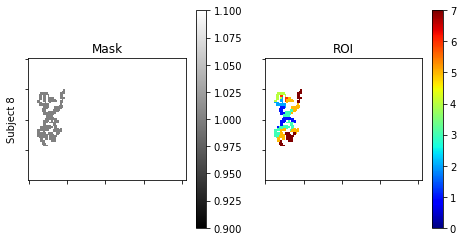

In [15]:
slice_idx = 25
plt.figure(figsize=(12, 4))
    
volume_brain_mask = view_data(brain_nii_shape, voxel_idx, np.ones_like(voxel_idx), save_to=None)
volume_brain_roi  = view_data(brain_nii_shape, voxel_idx, voxel_roi, save_to=None)
##
plt.subplot(1,3,1)
plt.imshow(volume_brain_mask[:,:,slice_idx], cmap='gray', interpolation='None')
plt.title('Mask')
plt.colorbar()
_=plt.ylabel('Subject %d'%s)
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.subplot(1,3,2)
plt.imshow(volume_brain_roi[:,:,slice_idx], cmap='jet', interpolation='None')
plt.clim([0,7])
plt.title('ROI')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])

# Make visual cortex masks

In [16]:
roi_map = {1: 'V1v', 2: 'V1d', 3: 'V2v', 4: 'V2d', 5: 'V3v', 6: 'V3d', 7: 'hV4', 8: 'VO1', 9: 'VO2', \
           10: 'PHC1', 11: 'PHC2', 12: 'MST', 13: 'hMT', 14: 'LO2', 15: 'LO1', 16: 'V3b', 17: 'V3a', \
           18: 'IPS0', 19: 'IPS1', 20: 'IPS2', 21: 'IPS3', 22: 'IPS4', 23: 'IPS5', 24: 'SPL1', 25: 'FEF',\
           0: 'other'}

for k,s in enumerate(subjects):
    print ('--------  subject %d  -------' % s)
    voxel_roi_full = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/prf-visualrois.nii.gz"%s)
    voxel_kast_full     = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/Kastner2015.nii.gz"%(s))
    general_mask_full  = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/nsdgeneral.nii.gz"%(s))
    ###
    
    brain_nii_shape = voxel_roi_full.shape
    print (brain_nii_shape)

    ###
    voxel_mask_full = (voxel_roi_full>0).flatten().astype(bool)
    voxel_joined_roi_full = np.copy(voxel_kast_full.flatten())  # take the kastner rois
    voxel_joined_roi_full[voxel_mask_full] = voxel_roi_full.flatten()[voxel_mask_full] # overwrite the prf visual rois
    voxel_joined_mask_full = (voxel_joined_roi_full>0).flatten().astype(bool)
    ###
    
    voxel_mask = voxel_joined_mask_full
    voxel_idx = np.arange(len(voxel_joined_mask_full))[voxel_mask]
    voxel_roi = voxel_joined_roi_full[voxel_mask]
        
    print ('(kastner selection length = %d)'%np.sum(voxel_kast_full>0))
    print ('mask selection length = %d'%np.sum(voxel_mask))
    print ('mask total length = %d'%len(voxel_mask))
    _ = view_data(brain_nii_shape, voxel_idx,  np.ones_like(voxel_idx), save_to=mask_root \
                  + "subj%02d/func1pt8mm/brainmask_nsdgeneral_1.0.nii"%s)

--------  subject 1  -------
(81, 104, 83)
(kastner selection length = 10971)
mask selection length = 11838
mask total length = 699192
--------  subject 2  -------
(82, 106, 84)
(kastner selection length = 9709)
mask selection length = 10325
mask total length = 730128
--------  subject 3  -------
(81, 106, 82)
(kastner selection length = 10560)
mask selection length = 11356
mask total length = 704052
--------  subject 4  -------
(85, 99, 80)
(kastner selection length = 8963)
mask selection length = 9470
mask total length = 673200
--------  subject 5  -------
(79, 97, 78)
(kastner selection length = 8989)
mask selection length = 9565
mask total length = 597714
--------  subject 6  -------
(85, 113, 83)
(kastner selection length = 11459)
mask selection length = 11827
mask total length = 797215
--------  subject 7  -------
(78, 95, 81)
(kastner selection length = 8440)
mask selection length = 9162
mask total length = 600210
--------  subject 8  -------
(80, 103, 78)
(kastner selection len

## Example

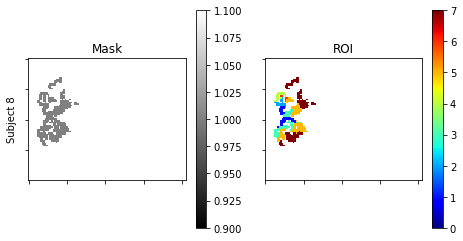

In [18]:
slice_idx = 25
plt.figure(figsize=(12, 4))
    
volume_brain_mask = view_data(brain_nii_shape, voxel_idx, np.ones_like(voxel_idx), save_to=None)
volume_brain_roi  = view_data(brain_nii_shape, voxel_idx, voxel_roi, save_to=None)
##
plt.subplot(1,3,1)
plt.imshow(volume_brain_mask[:,:,slice_idx], cmap='gray', interpolation='None')
plt.title('Mask')
plt.colorbar()
_=plt.ylabel('Subject %d'%s)
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.subplot(1,3,2)
plt.imshow(volume_brain_roi[:,:,slice_idx], cmap='jet', interpolation='None')
plt.clim([0,7])
plt.title('ROI')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])

# Make whole brain masks
## We need mask that are as tight as possible on the brain. The provided brainmasks are too loose and result in a prohibitive compute cost (almost half of the voxels can be entirely avoided)

In [20]:
subject = 1
brain_r2_full     = load_mask_from_nii(beta_root + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/R2.nii.gz"%(subject,))
brain_mask_full   = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/brainmask.nii.gz"%(subject))
brain_anat_full   = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/T1_to_func1pt8mm.nii.gz"%(subject))
brain_seg_full    = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/aseg.nii.gz"%(subject))
brain_roi_full    = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/Kastner2015.nii.gz"%(subject))
general_mask_full = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/nsdgeneral.nii.gz"%(subject))

brain_nii_shape = brain_mask_full.shape
brain_mask_full   = brain_mask_full.flatten().astype(bool)
general_mask_full = (general_mask_full==1).flatten().astype(bool)

voxel_seg_full = (brain_seg_full!=0).flatten()
voxel_idx_full = np.arange(len(brain_mask_full))
voxel_gen_full = (general_mask_full==1).flatten().astype(bool)
voxel_roi_full = brain_roi_full.flatten()

_ = view_data(brain_nii_shape, voxel_idx_full, brain_roi_full.flatten(), save_to=output_dir + "S%02d/roi_redo.nii"%(subject))
_ = view_data(brain_nii_shape, voxel_idx_full, brain_seg_full.flatten(), save_to=output_dir + "S%02d/aseg_redo.nii"%(subject))
_ = view_data(brain_nii_shape, voxel_idx_full, brain_anat_full.flatten(), save_to=output_dir + "S%02d/anat_redo.nii"%(subject))

voxel_seg_brain = voxel_seg_full[brain_mask_full]
voxel_idx_brain = voxel_idx_full[brain_mask_full]
voxel_roi_brain = voxel_roi_full[brain_mask_full]
voxel_gen_brain = voxel_gen_full[brain_mask_full]

voxel_seg_general = voxel_seg_full[general_mask_full]
voxel_idx_general = voxel_idx_full[general_mask_full]
voxel_roi_general = voxel_roi_full[general_mask_full]

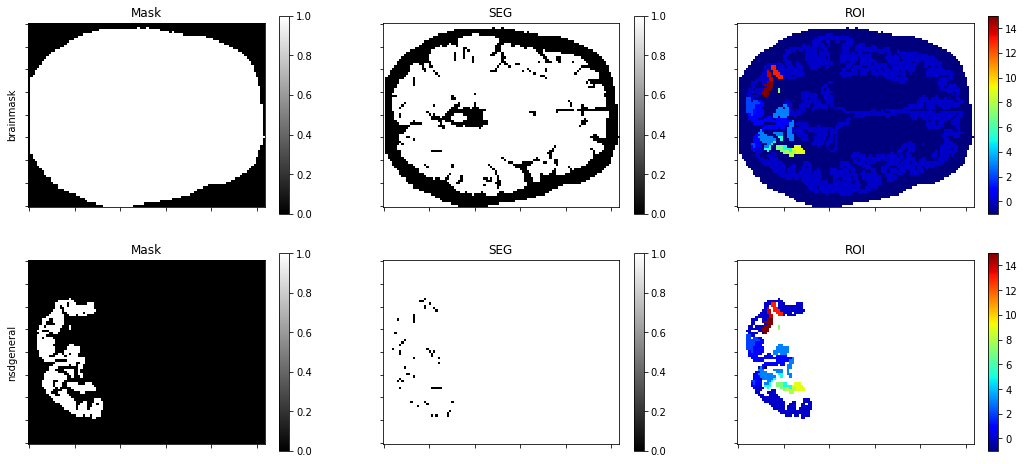

In [21]:
volume_brain_mask = view_data(brain_nii_shape, voxel_idx_full, brain_mask_full)
volume_brain_seg  = view_data(brain_nii_shape, voxel_idx_brain, voxel_seg_brain)
volume_brain_roi  = view_data(brain_nii_shape, voxel_idx_brain, voxel_roi_brain)

volume_general_mask = view_data(brain_nii_shape, voxel_idx_full, general_mask_full)
volume_general_seg  = view_data(brain_nii_shape, voxel_idx_general, voxel_seg_general)
volume_general_roi  = view_data(brain_nii_shape, voxel_idx_general, voxel_roi_general)

slice_idx = 40
fig = plt.figure(figsize=(18,8))
plt.subplot(2,3,1)
plt.imshow(volume_brain_mask[:,:,slice_idx], cmap='gray', interpolation='None')
plt.title('Mask')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.ylabel('brainmask')
plt.subplot(2,3,2)
plt.imshow(volume_brain_seg[:,:,slice_idx], cmap='gray', interpolation='None')
plt.title('SEG')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.subplot(2,3,3)
plt.imshow(volume_brain_roi[:,:,slice_idx], cmap='jet', interpolation='None')
plt.title('ROI')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.subplot(2,3,4)
plt.imshow(volume_general_mask[:,:,slice_idx], cmap='gray', interpolation='None')
plt.title('Mask')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.ylabel('nsdgeneral')
plt.subplot(2,3,5)
plt.imshow(volume_general_seg[:,:,slice_idx], cmap='gray', interpolation='None')
plt.title('SEG')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.subplot(2,3,6)
plt.imshow(volume_general_roi[:,:,slice_idx], cmap='jet', interpolation='None')
plt.title('ROI')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])

In [22]:
tight_mask = np.logical_or(np.logical_or(voxel_seg_full, voxel_gen_full), voxel_roi_full>=0)

voxel_idx_tight = voxel_idx_full[tight_mask]
voxel_roi_tight = voxel_roi_full[tight_mask]

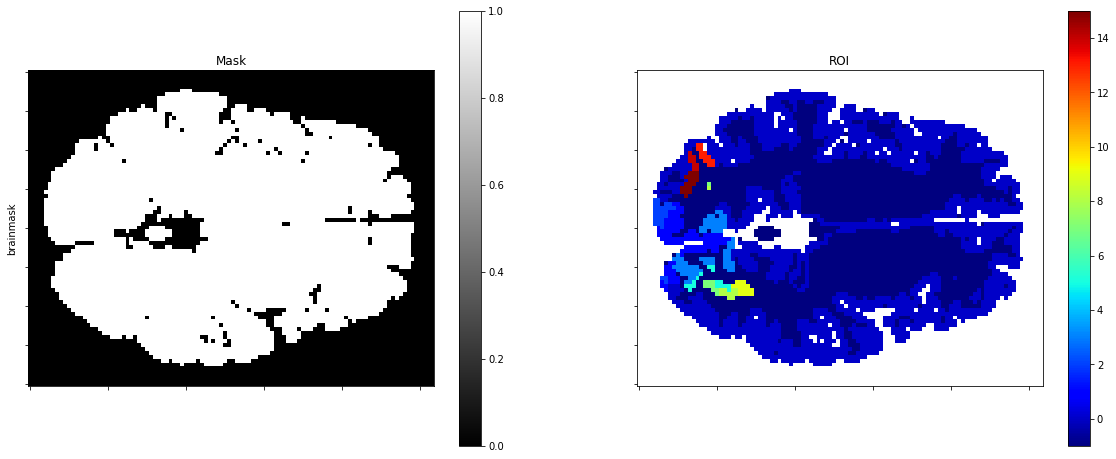

In [23]:
volume_tight_mask = view_data(brain_nii_shape, voxel_idx_full, tight_mask)
volume_tight_roi  = view_data(brain_nii_shape, voxel_idx_tight, voxel_roi_tight)

slice_idx = 40
fig = plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.imshow(volume_tight_mask[:,:,slice_idx], cmap='gray', interpolation='None')
plt.title('Mask')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.ylabel('brainmask')
plt.subplot(1,2,2)
plt.imshow(volume_tight_roi[:,:,slice_idx], cmap='jet', interpolation='None')
plt.title('ROI')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])

In [24]:
print ('tight masks voxel coverage = %d'%np.sum(tight_mask))
print ('original mask voxel coverage = %d'%np.sum(brain_mask_full))

tight masks voxel coverage = 206728
original mask voxel coverage = 370503


## Let's inflate the tight mask just a tiny bit to fill the ugly holes

In [25]:
def inflate1d(x):
    y = x.astype(np.float32)
    return 1.*y + 0.5*np.roll(y,-1,axis=0) + 0.5*np.roll(y,1,axis=0)

def inflate2d(x):
    y = inflate1d(x)
    return 1.*y + 0.5*np.roll(y,-1,axis=1) + 0.5*np.roll(y,1,axis=1)

def inflate3d(x):
    y = inflate2d(x)
    return 1.*y + 0.5*np.roll(y,-1,axis=2) + 0.5*np.roll(y,1,axis=2)

In [27]:
volume_inflated_mask = inflate3d(volume_tight_mask)>=1.

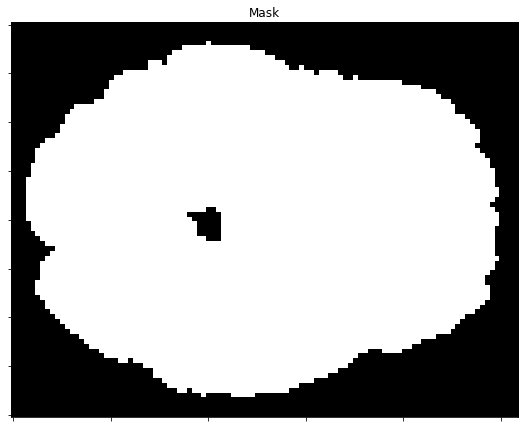

In [28]:
slice_idx = 40
fig = plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.imshow(volume_inflated_mask[:,:,slice_idx], cmap='gray', interpolation='None')
plt.title('Mask')
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])

In [29]:
print ('tight masks voxel coverage = %d'%np.sum(tight_mask))
print ('inflated tight masks voxel coverage = %d'%np.sum(volume_inflated_mask))
print ('original mask voxel coverage = %d'%np.sum(brain_mask_full))

tight masks voxel coverage = 206728
inflated tight masks voxel coverage = 238508
original mask voxel coverage = 370503


In [31]:
inflated_mask = volume_inflated_mask.flatten()

voxel_idx_inflated = voxel_idx_full[inflated_mask]
voxel_roi_inflated = voxel_roi_full[inflated_mask]

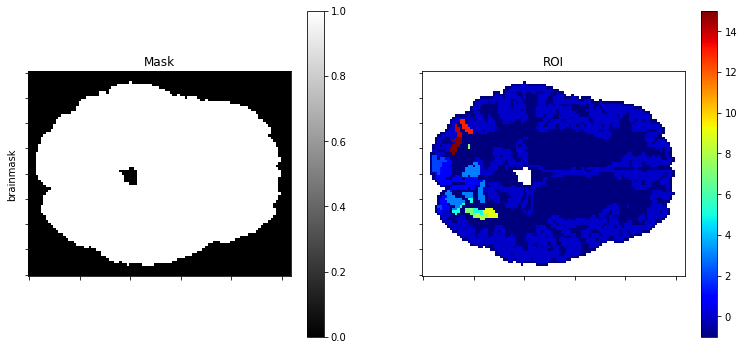

In [32]:
volume_inflated_mask = view_data(brain_nii_shape, voxel_idx_full, inflated_mask)
volume_inflated_roi  = view_data(brain_nii_shape, voxel_idx_inflated, voxel_roi_inflated)

slice_idx = 40
fig = plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.imshow(volume_inflated_mask[:,:,slice_idx], cmap='gray', interpolation='None')
plt.title('Mask')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.ylabel('brainmask')
plt.subplot(1,3,2)
plt.imshow(volume_inflated_roi[:,:,slice_idx], cmap='jet', interpolation='None')
plt.title('ROI')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])

# Create slightly inflated mask for all subjects

In [35]:
for s in subjects:
    print ('subject = %d' % s)
    brain_mask_full   = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/brainmask.nii.gz"%s)
    brain_seg_full    = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/aseg.nii.gz"%s)
    brain_roi_full    = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/Kastner2015.nii.gz"%s)
    general_mask_full = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/nsdgeneral.nii.gz"%s)
    
    brain_nii_shape = brain_mask_full.shape
    brain_mask_full   = brain_mask_full.flatten().astype(bool)
    general_mask_full = (general_mask_full==1).flatten().astype(bool)

    voxel_seg_full = (brain_seg_full!=0).flatten()
    voxel_idx_full = np.arange(len(brain_mask_full))
    voxel_gen_full = (general_mask_full==1).flatten().astype(bool)
    voxel_roi_full = brain_roi_full.flatten()
    ###
    tight_mask = np.logical_or(np.logical_or(voxel_seg_full, voxel_gen_full), voxel_roi_full>=0)
    volume_tight_mask = view_data(brain_nii_shape, voxel_idx_full, tight_mask)
    volume_inflated_mask = inflate3d(volume_tight_mask)>=1.
    inflated_mask = volume_inflated_mask.flatten()
    ###
    print ("   tight  \t<  inflated  \t<  original")
    print ("   %d  \t<  %d  \t<  %d"%(np.sum(tight_mask), np.sum(volume_inflated_mask.flatten()), np.sum(brain_mask_full.flatten())))
    _ = view_data(brain_nii_shape, voxel_idx_full, inflated_mask, save_to=mask_root + "subj%02d/func1pt8mm/brainmask_inflated_1.0.nii"%s)

subject = 1
   tight  	<  inflated  	<  original
   206728  	<  238508  	<  370503
subject = 2
   tight  	<  inflated  	<  original
   214038  	<  242606  	<  343107
subject = 3
   tight  	<  inflated  	<  original
   216430  	<  246730  	<  358199
subject = 4
   tight  	<  inflated  	<  original
   200341  	<  229642  	<  329650
subject = 5
   tight  	<  inflated  	<  original
   178358  	<  205761  	<  302566
subject = 6
   tight  	<  inflated  	<  original
   242203  	<  275204  	<  412281
subject = 7
   tight  	<  inflated  	<  original
   174944  	<  199944  	<  296155
subject = 8
   tight  	<  inflated  	<  original
   205938  	<  234961  	<  321595
